In [389]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
import datetime
import warnings
import copy
import xgboost as xgb

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from datetime import timedelta, date
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
os.chdir("/data/predictivePersona/nishant/DS TakeHome Assignment/data/")

In [391]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [336]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def filling_misisng_timestamp(train_pings_hourly):
    #datetime.date(2017, 6, 1) not in train_pings_hourly.groupby("driver_id")['date'].min().tolist()
    #returns false so every driver starts from 1 date 
    train_pings_hourly_full = pd.DataFrame(columns=['date','driver_id','online_hours'])
    for driver in train_pings_hourly.driver_id.unique():
        train_pings_hourly_one_day = pd.DataFrame()
        train_pings_hourly_one_day["date"] = pd.date_range("2017-06-01", periods=21)
        train_pings_hourly_one_day["driver_id"] = driver
        train_pings_hourly_one_day["online_hours"] = 0
        train_pings_hourly_full = train_pings_hourly_full.append(train_pings_hourly_one_day)
    
    train_pings_hourly_temp = pd.concat([train_pings_hourly_full,train_pings_hourly])
    train_pings_hourly_temp.date = pd.to_datetime(train_pings_hourly_temp.date)

    train_pings_hourly_final = train_pings_hourly_temp.groupby(['driver_id','date'])['online_hours'].agg('sum').reset_index()
    train_pings_hourly_final = train_pings_hourly_final.loc[train_pings_hourly_final["date"] <= datetime.date(2017, 6, 21) ]
    train_pings_hourly_final.sort_values(['driver_id','date'],inplace = True)
    return train_pings_hourly_final

In [639]:
def kmeans_clustering(drivers_details,k):
    scaler = MinMaxScaler()
    train_X_1 = scaler.fit_transform(drivers_details[["age","number_of_kids"]])

    enc = OneHotEncoder(handle_unknown = 'ignore')
    train_X_2 = enc.fit_transform(drivers_details["gender"].values.reshape(-1, 1)).toarray()

    train_X = np.concatenate([train_X_1,train_X_2],axis=1)

    km = KMeans(n_clusters=k)
    km = km.fit(train_X)
    return km

In [852]:
def kmeans_clustering_range(drivers_details):
    scaler = MinMaxScaler()
    train_X_1 = scaler.fit_transform(drivers_details[["age","number_of_kids"]])

    enc = OneHotEncoder(handle_unknown = 'ignore')
    train_X_2 = enc.fit_transform(drivers_details["gender"].values.reshape(-1, 1)).toarray()

    train_X = np.concatenate([train_X_1,train_X_2],axis=1)

    Sum_of_squared_distances = []
    K = range(3,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(train_X)
        Sum_of_squared_distances.append(km.inertia_)
        label = km.labels_
        sil_coeff = silhouette_score(train_X, label, metric='euclidean')
        print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil_coeff))

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()    

In [7]:
def timestamp_conversion(df):
    df['seconds'] =  (df["ping_timestamp"].dt.hour * 60 + df["ping_timestamp"].dt.minute) * 60 + df["ping_timestamp"].dt.second
    seconds_sorted = sorted(df.seconds.tolist())   
    diff = [t - s for s, t in zip(seconds_sorted, seconds_sorted[1:])]
    #Returning hours 
    return float((diff.count(15)*15)/3600)

In [321]:
def splitting_test_into_two(train,test):
    test.drop_duplicates(['driver_id','date'],keep='first',inplace=True)
    diff = set(test.driver_id.unique())- set(train.driver_id.unique())    
    return test[~test.driver_id.isin(diff)],test[test.driver_id.isin(diff)]

In [914]:
def feature_generation(df):
    df_1 = pd.merge(df,drivers_details,on='driver_id',how='left')
    final = pd.concat([pd.get_dummies(df_1['clusters'],prefix='cluster_type'),
                       pd.get_dummies(df_1['gender'],prefix='gender'),
                       pd.get_dummies(df_1['number_of_kids'],prefix='number_of_kids'),
                       df.drop(['driver_id'],axis=1)
                      ],axis=1)
    return final

In [10]:
drivers_details = pd.read_csv("drivers.csv")
train_pings     = pd.read_csv("pings.csv")
test            = pd.read_csv("test.csv")

Here we saw there are multiple entries for one driver so  we removed duplicate rows keeping first row 

In [ ]:
drivers_details.loc[drivers_details["driver_id"] == 800600 ]
drivers_details.drop_duplicates(['driver_id'],keep='first',inplace=True)

We also found there are new drivers in test data so we thought to do clustering on age gender and number of kids and what we will do is for new drivers the forecast will be just average of other drivers belonging to similar cluster.


We can also intoduce a coulmn as weekday or weekend driver means his on an average is more on whatever kind as fourth feature to cluster. 

For n_clusters=3, The Silhouette Coefficient is 0.5631251520430592
For n_clusters=4, The Silhouette Coefficient is 0.5476502819754389
For n_clusters=5, The Silhouette Coefficient is 0.5479131273677864
For n_clusters=6, The Silhouette Coefficient is 0.5262888827226521
For n_clusters=7, The Silhouette Coefficient is 0.5331711841833401
For n_clusters=8, The Silhouette Coefficient is 0.5148630674624518
For n_clusters=9, The Silhouette Coefficient is 0.5130192201404721
For n_clusters=10, The Silhouette Coefficient is 0.5018128326246619
For n_clusters=11, The Silhouette Coefficient is 0.509852093804915
For n_clusters=12, The Silhouette Coefficient is 0.5008441737182415
For n_clusters=13, The Silhouette Coefficient is 0.5230231547689905
For n_clusters=14, The Silhouette Coefficient is 0.5201942445039667


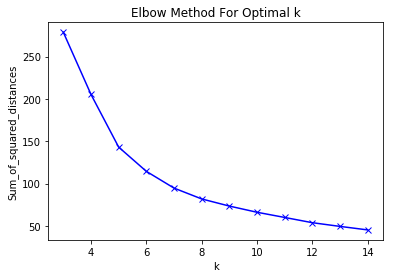

In [932]:
kmeans_clustering_range(drivers_details)

We saw using elbow curve that choosing 3 as cluster size makes sense as rmse decreases slowly after that we assigned cluster lables to dataset

In [641]:
drivers_details['clusters'] = kmeans_clustering(drivers_details,3).labels_

Here we are converting ping timestamps into online_hours also we saw there are missing dates for some drivers so we have to  fill them.

In [11]:
train_pings["ping_timestamp"] = pd.to_datetime(train_pings.ping_timestamp,unit='s')
train_pings["date"] = train_pings["ping_timestamp"].dt.date
train_pings_hourly = train_pings.groupby(["driver_id","date"]).apply(lambda x: timestamp_conversion(x)).reset_index()
train_pings_hourly = train_pings_hourly.rename(columns = {0:'online_hours'})
train_pings_hourly_final = filling_misisng_timestamp(train_pings_hourly)

We also saw there are some new drivers in test dataset which are unkown so we thought to split the test data into two parts one is test_known and other test_unknown 

In [37]:
len(set(test.driver_id.unique()) - set(train_pings.driver_id.unique()))

17

In [322]:
test_known_driver ,test_unknown_driver = splitting_test_into_two(train_pings,test)

In [1388]:
train_pings_hourly_final.to_csv("train_pings_hourly_final.csv")
test_known_driver.to_csv("test_known_driver.csv")
test_unknown_driver.to_csv("test_unknown_driver.csv")
drivers_details.to_csv("drivers_details.csv")

In [1387]:
os.getcwd()

'/data/predictivePersona/nishant/DS TakeHome Assignment/data'

These three functions down are responsible for getting feature maxtrix 
Basically averages,median and standard deviation are created for each weekofday indepndently.

In [1413]:
def data_prepare(df,end):
  
    df_week_weekend = update_week_weekend(df.iloc[:end,:]).add_suffix('_week_weekend_mean')

    df_mean = update_mean_features(df.iloc[:end,:]).add_suffix('_mean')

    df_median = update_median_features(df.iloc[:end,:]).add_suffix('_median')

    df_sd = update_std_features(df.iloc[:end,:]).add_suffix('_std')

    df_last_day = update_last_day_features(df.iloc[:end,:]).add_suffix('_last_day') 

    #df_last_2_day = update_last_2_day_features(df.iloc[:end,:]).add_suffix('_last_2_day')
        
    return pd.concat([df_mean,df_week_weekend,df_last_day['online_hours_last_day']],axis=1)    

In [1414]:
def update_mean_features(df): 
    return df.groupby(['weekday_type'])['online_hours'].mean().reset_index().pivot_table(values = 'online_hours',columns='weekday_type').reset_index()

def update_median_features(df): 
    return df.groupby(['weekday_type'])['online_hours'].median().reset_index()  

def update_std_features(df): 
    return df.groupby(['weekday_type'])['online_hours'].std().reset_index()  

def update_week_weekend_features(df):
    return df.groupby(['is_weekend'])['online_hours'].mean().reset_index()      

def update_week_weekend(df):
    df["is_weekend"] = df['weekday_type'].apply(lambda x: 1 if x >=5 else 0)      
    return update_week_weekend_features(df).pivot_table(values = 'online_hours',columns='is_weekend').reset_index()
    
def update_last_day_features(df):
    return df.sort_values('date').tail(1)['online_hours'].reset_index()

# def update_last_2_day_features(df):
#     return pd.DataFrame([[1,1.23,'Hello']], columns=('ABC'))df.sort_values('date').tail(2)['online_hours'].mean()

In [1415]:
def train_data_prepare(df,data_features,end=20):
    for index in range(end):
        data_features = data_features.append(data_prepare(df,index+1))
    return data_features

In [ ]:
#train_features = train_pings_hourly_final.loc[train_pings_hourly_final['driver_id'] <= 122580].groupby(['driver_id']).apply(lambda x: train_data_prepare(x,pd.DataFrame())).reset_index()

train_features = train_pings_hourly_final.groupby(['driver_id']).apply(lambda x: train_data_prepare(x,pd.DataFrame())).reset_index()

In [1407]:
train_features.shape

,driver_id,level_1,0_mean,0_week_weekend_mean,1_mean,1_week_weekend_mean,2_mean,3_mean,4_mean,5_mean,...,index,index_mean,index_week_weekend_mean,online_hours_1shift,online_hours_2shift,online_hours_3shift,online_hours_4shift,online_hours_5shift,online_hours_6shift,online_hours_last_day
0,111556,0,NaN,1.820833,NaN,NaN,NaN,1.820833,NaN,NaN,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,1.820833
1,111556,0,NaN,1.935417,NaN,NaN,NaN,1.820833,2.050000,NaN,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,2.050000
2,111556,0,NaN,1.935417,NaN,0.000000,NaN,1.820833,2.050000,0.000000,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,111556,0,NaN,1.935417,NaN,0.000000,NaN,1.820833,2.050000,0.000000,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,111556,0,3.812500,2.561111,NaN,0.000000,NaN,1.820833,2.050000,0.000000,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,3.812500
5,111556,0,3.812500,2.538542,2.470833,0.000000,NaN,1.820833,2.050000,0.000000,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,2.470833
6,111556,0,3.812500,2.460000,2.470833,0.000000,2.145833,1.820833,2.050000,0.000000,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,2.145833
7,111556,0,3.812500,2.483333,2.470833,0.000000,2.145833,2.210417,2.050000,0.000000,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,2.600000
8,111556,0,3.812500,2.649405,2.470833,0.000000,2.145833,2.210417,2.847917,0.000000,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,3.645833
9,111556,0,3.812500,2.649405,2.470833,0.000000,2.145833,2.210417,2.847917,0.000000,...,NaN,online_hours,online_hours,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [1152]:
#train_labels=train_pings_hourly_final.groupby('driver_id').apply(lambda group: group.iloc[1:][['date','online_hours','weekday_type']]).reset_index()
train_labels=train_pings_hourly_final.loc[train_pings_hourly_final['driver_id'] <= 200000].groupby('driver_id').apply(lambda group: group.iloc[1:][['date','online_hours','weekday_type']]).reset_index()
train_labels.drop(['level_1'],inplace=True,axis=1)


train_features.fillna(0,inplace=True)
train_features['weekday_type'] = train_labels['weekday_type']
train_features['date'] = train_labels['date']

In [965]:
train_features.to_csv("train_features.csv")
train_features = pd.read_csv("train_features.csv")
train_labels.to_csv("train_labels.csv")
train_labels = pd.read_csv("train_labels.csv")

In [1088]:
train_features.shape,train_labels.shape

((4480, 16), (4480, 4))

In [1104]:
train_columns

Index(['cluster_type_0', 'cluster_type_1', 'cluster_type_2', 'gender_FEMALE',
       'gender_MALE', 'number_of_kids_0', 'number_of_kids_1',
       'number_of_kids_2', 'number_of_kids_3', 'number_of_kids_4', '0_mean',
       '0_week_weekend_mean', '1_mean', '1_week_weekend_mean', '2_mean',
       '3_mean', '4_mean', '5_mean', '6_mean', 'online_hours_last_day',
       'weekday_type'],
      dtype='object')

In [1155]:
train_features.columns

Index(['driver_id', 'level_1', '0_mean', '0_week_weekend_mean', '1_mean',
       '1_week_weekend_mean', '2_mean', '3_mean', '4_mean', '5_mean', '6_mean',
       'index_mean', 'index_week_weekend_mean', 'online_hours_last_day',
       'weekday_type', 'date'],
      dtype='object')

In [ ]:
def rolling_mean_days_nishant(df,end):
    df_final = pd.DataFrame()
        for shift in range(1,7):
            df_final = pd.concat([df_final,df['online_hours'].rolling(shift).mean().bfill().reset_index().add_suffix("_"+str(shift)+"shift").reset_index()],axis=1)
        useful = [col for col in df_final.columns if 'online_' in col]
        return df_final[useful].reset_index()
    else 
        return 0


In [1409]:
model = xgb.XGBRegressor(learning_rate =0.1,n_estimators=1000, max_depth=50,nthread=4,seed=27)

#model = xgb.XGBRegressor()

train = (feature_generation(train_features.drop(['level_1','date','index_mean','index_week_weekend_mean'],axis=1)))
train_columns = train.columns

model.fit(train,train_labels['online_hours'],eval_metric='rmse', verbose = True)

KeyError: "['date'] not found in axis"

In [1092]:
def add_missing_dummy_columns( d, train_columns ):
    missing_cols = set( train_columns ) - set( d.columns )
    for c in missing_cols:
        d[c] = 0
    return d

In [1157]:
train_modified = copy.copy(train_pings_hourly_final)
train_modified = train_modified.loc[train_modified['driver_id'] <=200000]
train_modified.weekday_type=train_modified.weekday_type.astype('int64')
start_date = datetime.date(2017, 6, 21)
end_date = datetime.date(2017, 6, 28)
for date in daterange(start_date, end_date):
    print("generating Dataset for date",date)
    test_features_initial = train_modified.groupby(['driver_id']).apply(lambda x: data_prepare(x,end=int(date.day))).reset_index()
    test_features_initial['date']=pd.to_datetime(date)+pd.DateOffset(1)
    test_features_initial['weekday_type']=test_features_initial['date'].dt.weekday
    to_predict_datfarme = add_missing_dummy_columns(feature_generation(test_features_initial.drop(['level_1','date','index_mean','index_week_weekend_mean'],axis=1)),columns)
    
    y_test_initial=model.predict(to_predict_datfarme[train_columns])
    print("Forecasted for date",date+pd.DateOffset(1))
    
    #train_modified needs to be changed  
    forecasted = pd.DataFrame()
    forecasted['online_hours'] = y_test_initial
    forecasted['driver_id'] = test_features_initial['driver_id']
    forecasted['date'] = test_features_initial['date']
    forecasted['weekday_type'] = test_features_initial['date'].dt.weekday
    
    train_modified = train_modified.append(forecasted)  

generating Dataset for date 2017-06-21
Forecasted for date 2017-06-22 00:00:00
generating Dataset for date 2017-06-22
Forecasted for date 2017-06-23 00:00:00
generating Dataset for date 2017-06-23
Forecasted for date 2017-06-24 00:00:00
generating Dataset for date 2017-06-24
Forecasted for date 2017-06-25 00:00:00
generating Dataset for date 2017-06-25
Forecasted for date 2017-06-26 00:00:00
generating Dataset for date 2017-06-26
Forecasted for date 2017-06-27 00:00:00
generating Dataset for date 2017-06-27
Forecasted for date 2017-06-28 00:00:00


In [1158]:
actual_test = test_known_driver.loc[test_known_driver['driver_id'] <= 200000].sort_values(['driver_id','date'])

#actual_test = test_known_driver.loc[test_known_driver['driver_id'] == 111556].sort_values(['driver_id','date'])
predicted_test=train_modified.loc[train_modified['date']>='2017-6-22'].sort_values(['driver_id','date'])

In [1159]:
actual_test.shape,predicted_test.shape

((1568, 4), (1568, 4))

In [943]:
actual_test.date = pd.to_datetime(actual_test.date)
final = pd.merge(actual_test,predicted_test,on=['driver_id','date'])

In [1102]:
final.loc[np.abs(final['online_hours_y']-final['online_hours_x'])>3].head(10)

,driver_id,date,online_hours_x,predicted_hours,online_hours_y,weekday_type
7,111575,2017-06-22,9,driver_id online_hours 1 111575 3...,5.743627,3
11,111575,2017-06-26,9,driver_id online_hours 1 111575 3...,5.736044,0
13,111575,2017-06-28,0,driver_id online_hours 1 111575 3...,5.061144,2
23,111839,2017-06-24,9,driver_id online_hours 3 111839 6...,5.836032,5
24,111839,2017-06-25,10,driver_id online_hours 3 111839 6...,6.276585,6
27,111839,2017-06-28,10,driver_id online_hours 3 111839 6...,6.347242,2
38,112609,2017-06-25,8,driver_id online_hours 5 112609 4...,3.175485,6
57,113043,2017-06-23,8,driver_id online_hours 8 113043 3...,3.912097,4
60,113043,2017-06-26,8,driver_id online_hours 8 113043 3...,4.142135,0
61,113043,2017-06-27,8,driver_id online_hours 8 113043 3...,4.292636,1


In [1160]:
mean_squared_error(actual_test.online_hours, predicted_test.online_hours)

5.528245375352686

Mean squared error of the average model is 7 so Xgboost is doing at least better  than the naive approach. 

In [1105]:
average_driver_online_hours = train_pings_hourly_final.groupby('driver_id')['online_hours'].mean().reset_index()
combined = pd.merge(test_known_driver,average_driver_online_hours,on='driver_id',how='left')
mean_squared_error(combined.online_hours_x, combined.online_hours_y)

6.979308676739439

In [1119]:
test_unknown_driver["date"] = pd.to_datetime(test_unknown_driver["date"])
combined_1 = pd.merge(pd.merge(test_unknown_driver,predicted_test,on=['driver_id','date'],how = 'inner'),drivers_details,on=['driver_id'],how = 'inner')

In [1120]:
mean_squared_error(combined_1.online_hours_x, combined_1.online_hours_y)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.